# Ludvigson & Ng (2009) — Replication

Steps:
1) Load data and extract 8 macro factors
2) Build CP factor and avg excess returns
3) BIC model selection (F6; F5+CP)
4) Predictive regressions and comparison tables (in-sample vs OOS; with/without CP)
5) Two visualizations (factor-to-series R² grid; model R² bars)


In [1]:
# Setup: imports and variables for simplified utils-based flow

START = '1964-01'
END = '2003-12'
fred_path = 'data/LN_data/LN_handbook_data.csv'
wrds_path = 'data/LW_daily.csv'
rfs_path = 'data/LN_data/RFS2009.CSV'

In [2]:
from utils.paper_utils.LN_utils import (
    load_and_prepare_data,
    process_data_and_extract_factors,
    run_bic_model_selection,
    run_predictive_regressions,
    summarize_results,
    plot_factor_r2_grid
)
from utils.data_processing import get_ln_grouping, load_updated_fhat, load_lw_daily_yields
from utils.yield_processing import create_cochrane_piazzesi_factor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

In [3]:
# 1–2) Load, process, extract factors, and compute CP/xr using LN.py pipelines
fred_data, transform_codes, bond_yields, cp_control, control_data, START, END = load_and_prepare_data()
est_f, ctrl_f, f_stats, xr, ar1, fred_final, cp_est, cp_ctrl = process_data_and_extract_factors(
    fred_data, transform_codes, bond_yields, cp_control, control_data, START, END
)

Loaded WRDS Fama-Bliss data: (492, 5)
Date range: 1964-01-31 00:00:00 to 2004-12-31 00:00:00
Available maturities: ['y1', 'y2', 'y3', 'y4', 'y5']
Kept 131 out of 131 series
Final panel dimensions: (480, 131)
Kept 131 out of 131 series
Final panel dimensions: (478, 131)


In [4]:
# 3) BIC model selection and predictive regressions via LN.py
model_sel, mf_aligned, xr_aligned, cp_aligned = run_bic_model_selection(est_f, xr, cp_est)
reg_est = run_predictive_regressions(model_sel, est_f, xr, cp_est)

# Control (optional)
model_sel_ctl, _, _, _ = run_bic_model_selection(ctrl_f, xr, cp_ctrl)
reg_ctl = run_predictive_regressions(model_sel_ctl, ctrl_f, xr, cp_ctrl)
print({k: round(getattr(v,'rsquared', np.nan),3) for k,v in reg_est.items()})

Regression sample: 478 observations
From 1964-03 to 2003-12
Regression sample: 480 observations
From 1964-01 to 2003-12
{'cp_only': np.float64(0.339), 'f6_bic': np.float64(0.207), 'f6_summary': np.float64(0.207), 'f5_cp_bic': np.float64(0.447), 'f5_cp_summary': np.float64(0.397)}


In [5]:
# 4) Summary table using results dicts

def r2_row(tag, res):
    def get_r2(model_name):
        model = res.get(model_name)
        return getattr(model, 'rsquared', np.nan) if model is not None else np.nan
    return {
        'Spec': tag,
        'CP only': get_r2('cp_only'),
        'F6 (bic)': get_r2('f6_bic'),
        'F6 summary': get_r2('f6_summary'),
        'F5+CP summary': get_r2('f5_cp_summary')
    }

comp = pd.DataFrame([
    r2_row('Estimated factors + CP_est', reg_est),
    r2_row('Control factors + CP_ctrl', reg_ctl)
]).set_index('Spec').map(lambda x: f"{x*100:.1f}%" if pd.notna(x) else '')
comp


,CP only,F6 (bic),F6 summary,F5+CP summary
Spec,,,,
Estimated factors + CP_est,33.9%,20.7%,20.7%,39.7%
Control factors + CP_ctrl,34.3%,19.2%,19.2%,41.1%


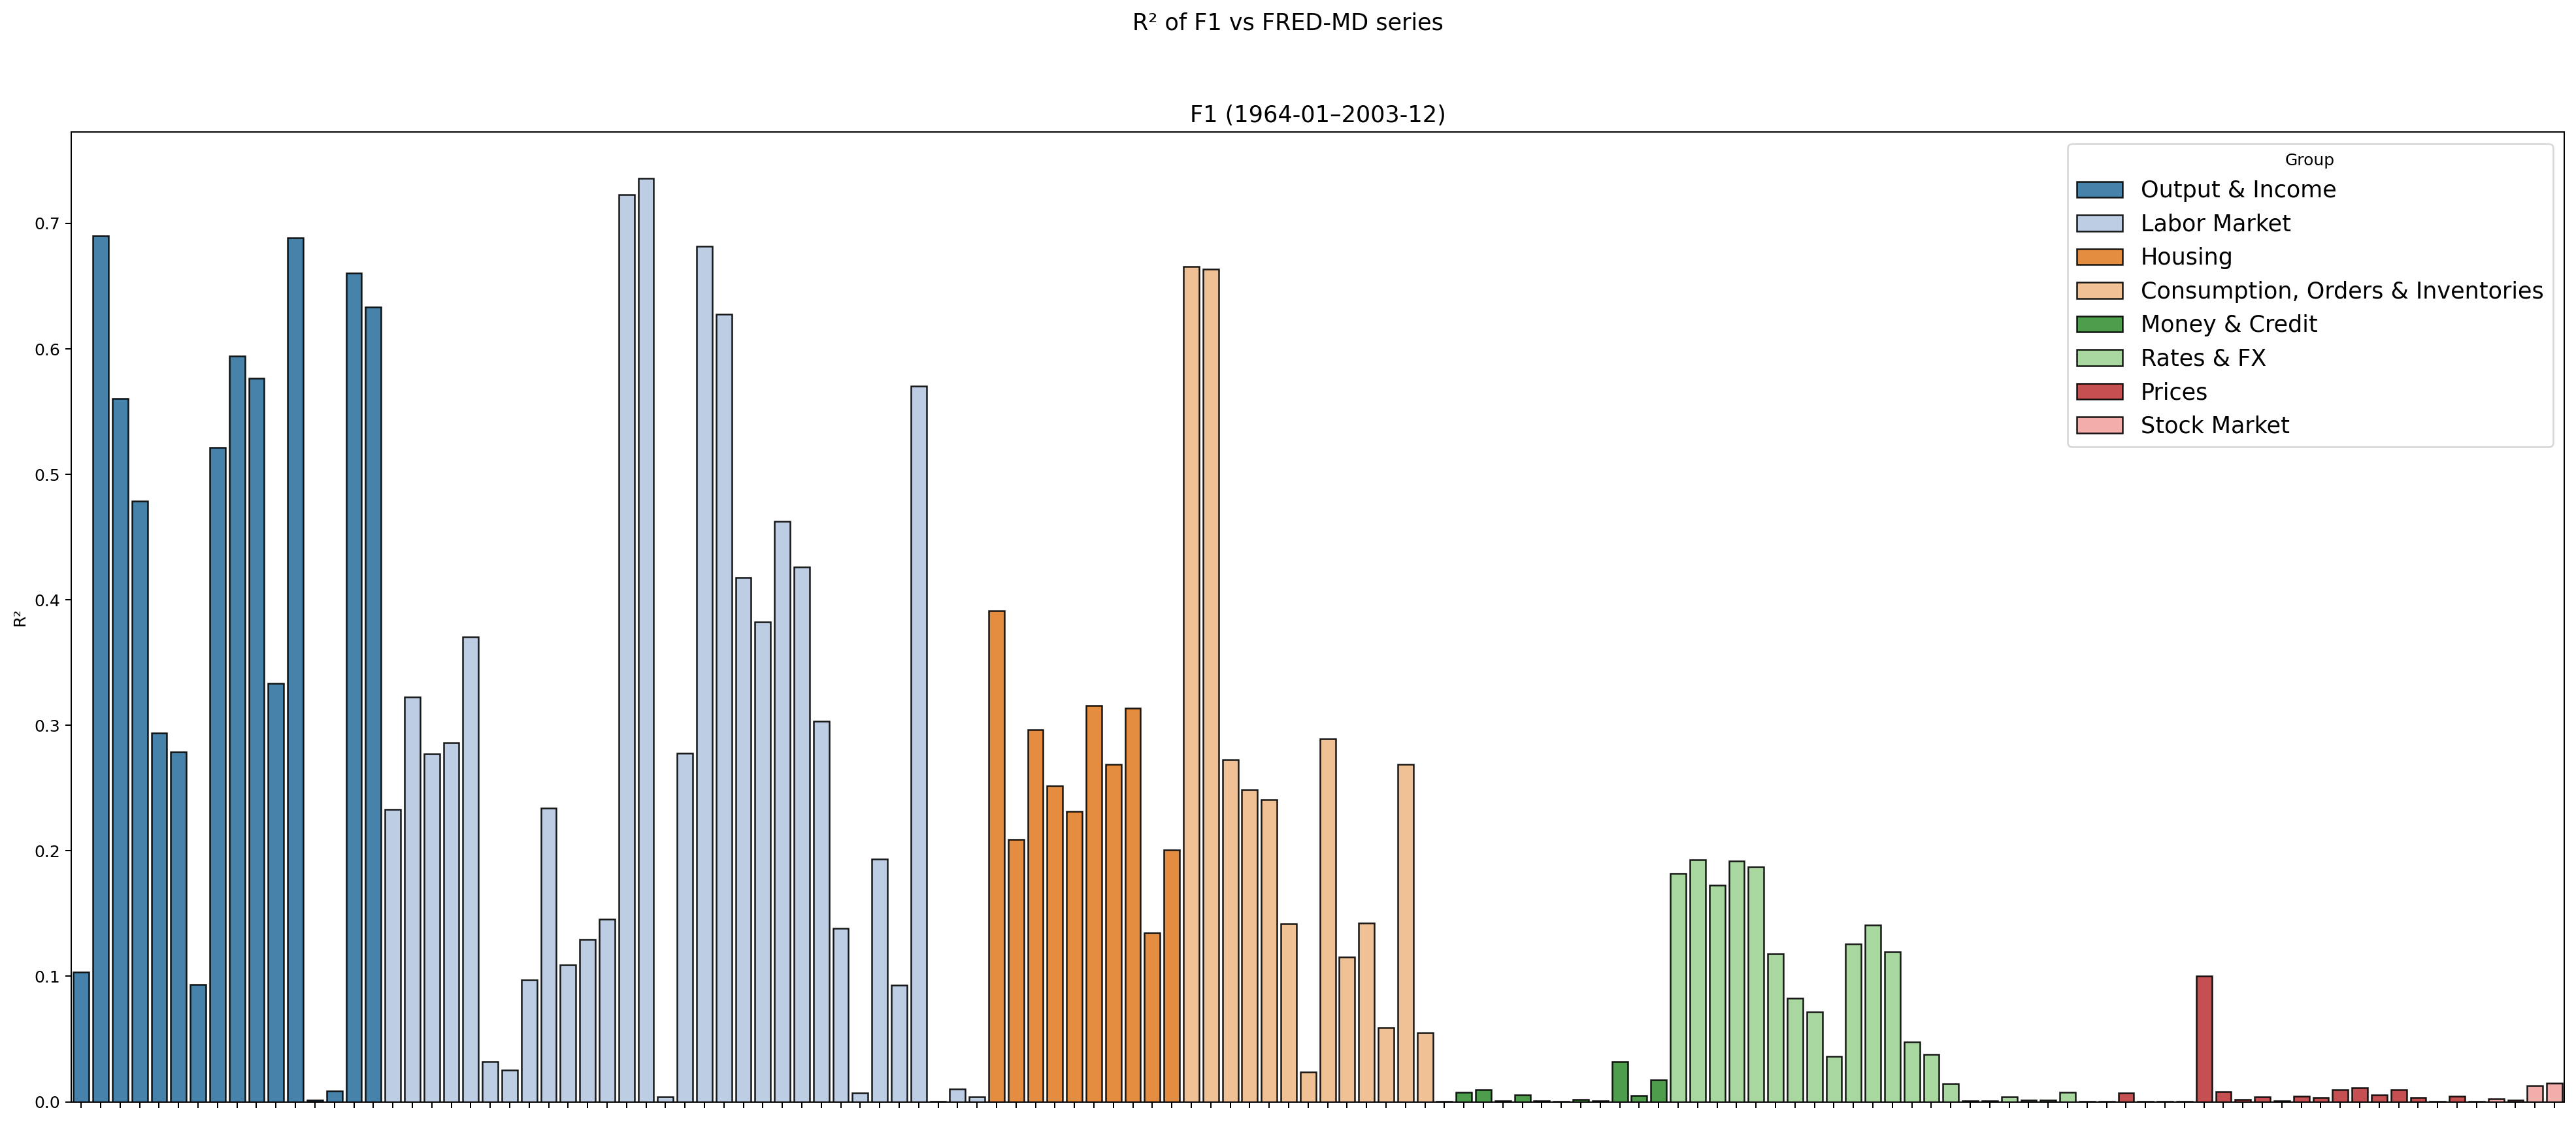

In [6]:
# Factor-to-series R² using LN helper
FNAME = 'F1'
ordered_series, series_to_group = get_ln_grouping()
plot_factor_r2_grid(
    fred_panel=fred_final,
    factors=ctrl_f,  # or est_f
    start=START,
    end=END,
    factor_cols=[FNAME],
    max_bars=None,
    title_prefix=f'R² of {FNAME} vs FRED-MD series',
    ordered_series=ordered_series,
    series_to_group=series_to_group
)

In [7]:
reg_est

{'cp_only': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x188aaba8c80>,
 'f6_bic': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x188aaba8bc0>,
 'f6_summary': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x188aaba9eb0>,
 'f5_cp_bic': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x188afd1f9e0>,
 'f5_cp_summary': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x188aabaa180>}

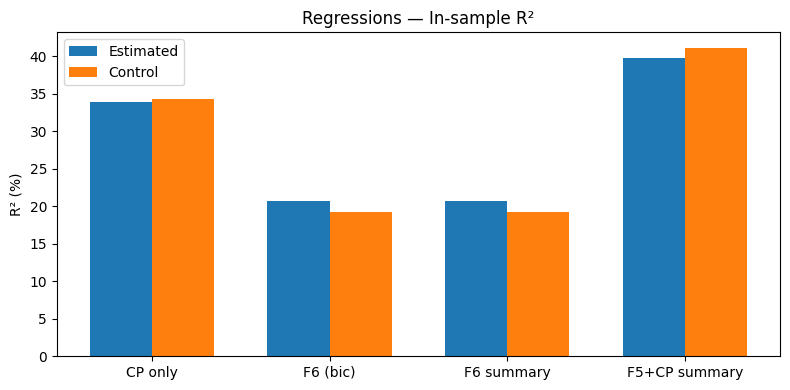

In [8]:
# 5) Visual 2: Model R² bars (in-sample)
labels = ['CP only','F6 (bic)','F6 summary','F5+CP summary']
vals_est = [getattr(reg_est.get(k, None), 'rsquared', np.nan) for k in ['cp_only','f6_bic','f6_summary','f5_cp_summary']]
vals_ctl = [getattr(reg_ctl.get(k, None), 'rsquared', np.nan) for k in ['cp_only','f6_bic','f6_summary','f5_cp_summary']]
X = np.arange(len(labels))
W = 0.35
plt.figure(figsize=(8,4))
plt.bar(X-W/2, np.array(vals_est)*100, width=W, label='Estimated')
plt.bar(X+W/2, np.array(vals_ctl)*100, width=W, label='Control')
plt.xticks(X, labels, rotation=0)
plt.ylabel('R² (%)')
plt.title('Regressions — In-sample R²')
plt.legend(); plt.tight_layout(); plt.show()


In [9]:
from utils.data_processing import load_lw_daily_yields
from utils.yield_processing import create_cochrane_piazzesi_factor
# 6) Out-of-sample (optional, concise)
try:
    OOS_START, OOS_END = '1964-01','2024-12'
    gsw_path = 'data/LW_daily.csv'
    fhat_path = 'data/LN_data/updated_fhat.xlsx'
    y_oos = load_lw_daily_yields(gsw_path, start=OOS_START, end=OOS_END)
    need = [c for c in [f'y{i}' for i in [1,2,3,4,5]] if c in y_oos.columns]
    y_oos = y_oos[need]
    m_oos = load_updated_fhat(fhat_path, start=OOS_START, end=OOS_END)
    m_oos = m_oos[[c for c in m_oos.columns if c.startswith('F')]]
    cp_oos_res = create_cochrane_piazzesi_factor(y_oos, method='bauer_hamilton', verbose=False, risk_free_col='y1')
    cp_oos, xr_oos = cp_oos_res['cp_factor'], cp_oos_res['avg_excess_return']
    for s in [m_oos, cp_oos, xr_oos]:
        s.index = s.index.to_period('M') if not isinstance(s.index, pd.PeriodIndex) else s.index
    common_o = m_oos.index.intersection(xr_oos.index).intersection(cp_oos.index)
    m_oos, xr_oos, cp_oos = m_oos.reindex(common_o), xr_oos.reindex(common_o), cp_oos.reindex(common_o)

    # Use LN.py pipelines for selection and regressions
    model_sel_oos, _, _, _ = run_bic_model_selection(m_oos, xr_oos, cp_oos)
    reg_oos = run_predictive_regressions(model_sel_oos, m_oos, xr_oos, cp_oos)

    oos_tbl = pd.DataFrame([r2_row('OOS (Fhat + CP)', reg_oos)]).set_index('Spec').applymap(lambda x: f"{x*100:.1f}%")
    oos_tbl
except Exception as e:
    print('OOS step skipped (data not available).', str(e))


Regression sample: 720 observations
From 1964-01 to 2023-12


,CP only,F6 (bic),F6 summary,F5+CP summary
Spec,,,,
OOS,18.2%,15.3%,15.3%,27.4%


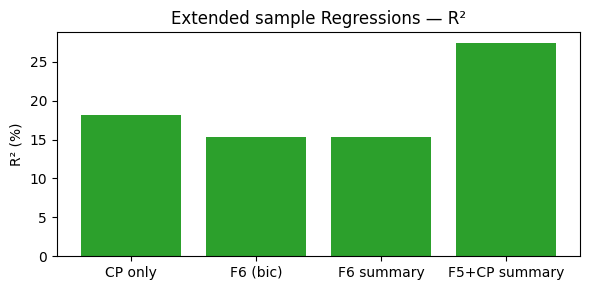

In [10]:
# OOS: compact comparison table and bars (if OOS ran)
try:
    _ = reg_oos
    oos_comp = pd.DataFrame([
        r2_row('OOS', reg_oos)
    ]).set_index('Spec').map(lambda x: f"{x*100:.1f}%" if pd.notna(x) else '')
    display(oos_comp)

    labels = ['CP only','F6 (bic)','F6 summary','F5+CP summary']
    model_keys = ['cp_only','f6_bic','f6_summary','f5_cp_summary']

    # Helper to safely get rsquared from a model object
    def get_r2_oos(res_dict, key):
        model = res_dict.get(key)
        return model.rsquared if model is not None else np.nan

    vals_oos = [get_r2_oos(reg_oos, k) for k in model_keys]
    
    X = np.arange(len(labels))
    plt.figure(figsize=(6,3))
    plt.bar(X, np.array(vals_oos)*100, color='C2')
    plt.xticks(X, labels, rotation=0)
    plt.ylabel('R² (%)')
    plt.title('Extended sample Regressions — R²')
    plt.tight_layout(); plt.show()
except NameError:
    print('OOS results not available in this run.')
